# Week 3

In deze week gaan we vooral focussen op een aantal technieken om te werken met visuele inputs.
Als eerste gaan we een aantal technieken zien hoe je deze data op een eenvoudige manier kan inlezen en verwerken.
Daarna gaan we een aantal veelgebruikte technieken zijn om meer data aan te maken via varianten van bestaande data.
Ten slotte ga je leren hoe je op een efficiente manier modellen kan trainen om classificatie of regressie uit te voeren op een dataset van beelden.

## Data inlezen

Zoals je vorige week geoefend hebt kan tf.data gebruikt worden om csv's in te lezen.
Natuurlijk is het ook heel eenvoudig om deze met panda's in te lezen, te verwerken en te gebruiken in tensorflow.
Echter is het heel wat moelijker als je werkt met visuele of tekstuele data aangezien deze data vaak in aparte files zit en/of verschillende dimensies heeft.
In dit stuk ga je een aantal voorbeelden zien hoe je deze soorten data kan inlezen en verwerken.

### Images inlezen

Er zijn twee veelgebruikte manieren en 1 minder gebruikte om beelden in te lezen in tensorflow:
* tf.keras.utils.image_dataset_from_directory (tf.data)
* list_files() en map() om in te lezen (tf.data)
* Sequence (tensorflow)

De voordelen van te werken met tf.data functionaliteit is dat het typsich veel sneller zal gaan en dat het eenvoudiger is om functionaliteiten in te bouwen voor performantieoptimalisatie zoals prefetching of shuffling.

In [1]:
# prep code
import numpy as np
import os
import tensorflow as tf 
import matplotlib.pyplot as plt
import pathlib
import time

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
# Voorbeeld tf.keras.utils.image_dataset_from_directory
# Hierbij is de folderstructuur heel belangrijk
# In de datadirectory moeten een aantal sub-directories aanwezig zijn (1 per klasse)
# In deze subdirectories staan de figuren. De namen van de subdirectories worden gebruikt als label
# Merk op dat regressie niet mogelijk is op deze manier
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",              # geef het trainingsgedeelte terug van de dataset
    seed=123,                       # belangrijk zodat de train en validatie niet overlappen door randomness
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,           # validatie data is 20% van de dataset
    subset="validation",            # geef het validatie gedeelte terug 
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


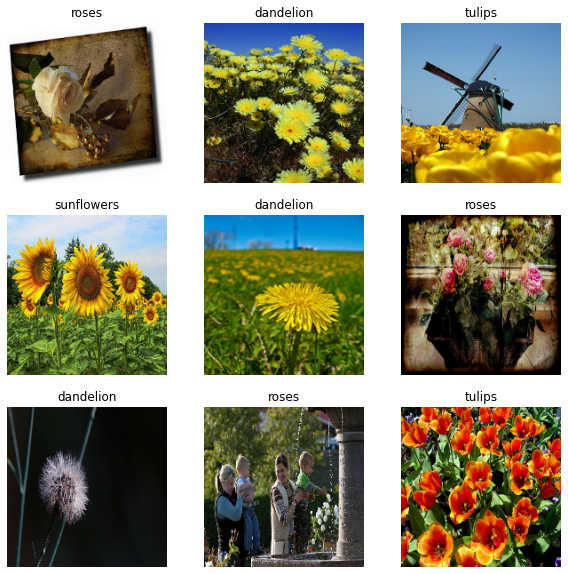

In [7]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):       # take = geef me de eerste batch
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)         # i + 1 is welk figuurtje je wilt tekenen
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


In [10]:
# voor performantie wil je dit vaak hebben staan
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
num_classes = 5
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),      # (32, 180, 180, 3)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")        # (batch size, aantal neuronen, 5)
])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


92/92 [==============================] - 5s 56ms/step - loss: 29.6256 - accuracy: 0.2881 - val_loss: 50.6491 - val_accuracy: 0.2275
Epoch 2/3
92/92 [==============================] - 1s 15ms/step - loss: 23.7577 - accuracy: 0.3283 - val_loss: 17.1024 - val_accuracy: 0.3774
Epoch 3/3
92/92 [==============================] - 1s 14ms/step - loss: 22.1975 - accuracy: 0.3512 - val_loss: 34.8814 - val_accuracy: 0.3270


In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 flatten (Flatten)           (None, 97200)             0         
                                                                 
 dense_3 (Dense)             (None, 5)                 486005    
                                                                 
Total params: 486,005
Trainable params: 486,005
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Voorbeeld tf.data voor fijnere controle
# vooral voor als de dataset niet voldoet aan de structuur om het vorige voorbeeld te gebruiken
# bijvoorbeeld als er een csv is met een imagepath en een bijhorende waarde

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)  # alle files in de dataset
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

# train en val splitsen
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)       # 80 % laatste
val_ds = list_ds.take(val_size)         # 20 % eerste

def process_path(file_path):
    # read the image = input = x
    x = tf.io.read_file(file_path)
    x = tf.io.decode_jpeg(x, channels=3) # 3 omdat het rgb
    x = tf.image.resize(x, [img_height, img_width])

    # haal de klassenaam uit de pathnaam
    parts = tf.strings.split(file_path, os.path.sep)        # os.path.sep is forward of backwards slash, afhankelijk van OS
    one_hot = parts[-2] == class_names   # foldernaam is het voorlaatste in het pad -> [ 0, 0, 1, 0, 0]
    y = tf.argmax(one_hot)          # 2

    return x, y

# belangrijk om eerst geshuffeld te hebben, anders zitten ze gesorteerd per klasse
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# hier herhaalt het vorige zich

In [ ]:
# derde voorbeeld met Sequence
# het is best om dit enkel te gebruiken als je pure python code gebruikt bij het verwerken van de beelden (bijvoorbeeld met de PIL library)
# dit omdat de Sequence klassen niet geoptimaliseerd zijn op c++ threads maar met python multiprocessing

from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.
class CIFAR10Sequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

### Tekst inlezen

Net zoals voor het werken  met beelden is het vaak niet mogelijk om alle data in 1 bestand uit te lezen wanneer je werkt met tekstuele inputs.
Ook voor dit soort data zijn een aantal handige tools aanwezig binnen tf.data.
Deze zijn:
* tf.keras.utils.text_dataset_from_directory
* list_files() en map() om in te lezen (tf.data)
* tf.data.TextLineDataset

In [16]:
# prep code
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = tf.keras.utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

dataset_dir = pathlib.Path(dataset_dir).parent

# welke subdirectories/labels zijn er
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

# example file
sample_file = train_dir/'python/1755.txt'

with open(sample_file) as f:
  print(f.read())

# data example 3
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = tf.keras.utils.get_file(name, origin=DIRECTORY_URL + name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



[WindowsPath('C:/Users/jens.baetens3/.keras/datasets/butler.txt'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/cifar-10-batches-py'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/cifar-10-batches-py.tar.gz'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/cowper.txt'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/derby.txt'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/fashion-mnist'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/flower_photos'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/flower_photos.tgz'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/IMAGE_5.jpg'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/labels.txt'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/mnist.npz'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/style_predict.tflite'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/style_transform.tflite'),
 WindowsPath('C:/Users/jens.baetens3/.keras/datasets/train.csv')]

In [17]:
# Methode 1 met tf.keras.utils.text_dataset_from_directory

# Hierbij is de folderstructuur heel belangrijk
# In de datadirectory moeten een aantal sub-directories aanwezig zijn (1 per klasse)
# In deze subdirectories staan de tekstbestanden. De namen van de subdirectories worden gebruikt als label
# Merk op dat regressie niet mogelijk is op deze manier

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',      # only pick training data
    seed=seed)

# voorbeeld inputs
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

# welk label voor welke klasse
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)


raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',    # only pick validation data
    seed=seed)

test_dir = dataset_dir/'test'
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

VOCAB_SIZE = 10000

binary_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)           # breid de dimensies uit door er achteraan 1 bij te plaatsen
  return binary_vectorize_layer(text), label

def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)

print("'binary' vectorized question:",
      binary_vectorize_text(first_question, first_label)[0])        # multi-hot encoding

print("'int' vectorized question:",
      int_vectorize_text(first_question, first_label)[0])           # sequentie van woorden -> elk nummer komt overeen met woord x uit de lijst

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the secon

In [ ]:
# Methode 2 met list-files() - meer controle over wat er gebeurd
# vooral voor als de dataset niet voldoet aan de structuur om het vorige voorbeeld te gebruiken
# bijvoorbeeld als er een csv is met een bestandspath en een bijhorende waarde

# Idem aan hierboven dus ga ik niet uitwerken

In [18]:
# Methode 3 met TextLineDataset
# Vorige methoden zagen de volledige bestanden als 1 input
# Echter zijn er ook vaak datasets waar elke lijn een aparte input is
# Dit doet deze methode


labeled_data_sets = []

def labeler(example, index):
  return example, tf.cast(index, tf.int64)      # label = index van boek (herkennen van schrijver bijvoorbeeld)

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)
  
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)      # groepeer de files in 1 dataset

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

for text, label in all_labeled_data.take(10):
  print("Sentence: ", text.numpy())
  print("Label:", label.numpy())

Sentence:  b'fire with wine wherever it was burning, and then his brothers and'
Label: 2
Sentence:  b'But might the battle-shout of Ajax once'
Label: 0
Sentence:  b"Station'd, devoted him for Ilium's sake."
Label: 0
Sentence:  b'To spoil the dead. First, freely let him pass'
Label: 0
Sentence:  b'That on the champain lay. The bull-hide guard'
Label: 0
Sentence:  b'And raging, \'mid the ships maintains the war."'
Label: 1
Sentence:  b"And to th' Immortals all address'd his pray'r:"
Label: 1
Sentence:  b"Slack'd the retaining shrouds, and quickly struck"
Label: 1
Sentence:  b'Such toils the archer of the silver bow,'
Label: 0
Sentence:  b'Should we re-enter Ilium, driven to flight'
Label: 0


In [19]:
tf.version.VERSION

'2.11.1'

## Data augmentation

Het verzamelen van voldoende data kan zeer tijdrovend en kostelijk zijn.
Daarom zou het handig zijn om op een automatische manier extra data aan te maken.
Dit is wat data augmentation doet en wordt vaak gebruikt wanneer er gewerkt wordt met visuele of auditieve data.
De code hieronder zal vooral een voorbeeld zijn van hoe je data augmentatie kan toepassen op beelden/images.
Hierbij gaan we voor het trainen op een random manier een variatie maken van de figuur.
Doordat er meerdere epochs gebruikt worden bij training zullen er op die manier meerdere varianten van elke figuur gebruikt worden bij training.

Alle standaard geincludeerde layers voor data augmentation vind je [hier](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation).

Data augmentation kan je meestal toepassen zonder problemen. Zeker de opties waarbij geen pixels verdwijnen geven normaal geen issues.
Let echter wel op als je roteert of cropt en hetgene dat je moet detecteren aan de rand van je scherm ligt, dat dat object kan verdwijnen.
Indien je genoeg epochs gebruikt zou dit echter geen groot probleem mogen zijn door compensatie in de andere epochs.

In [23]:
# figuur om een aantal varianten van een image te tekenen (eerste figuur is het origineel)
def draw_figures(data_augmentation, image):
    
    tmp = tf.cast(tf.expand_dims(image, 0), tf.float32)
   
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        if i > 0:
            augmented_image = data_augmentation(tmp)
            plt.imshow(augmented_image[0])
        else:
            plt.imshow(image)
        plt.axis("off")

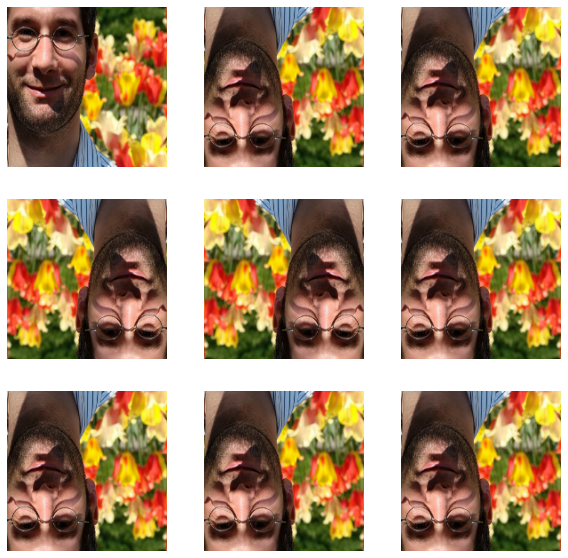

In [25]:
image = image_batch[i]

# flip horizontally and/or vertically

data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip( )
])

draw_figures(data_augmentation, image)

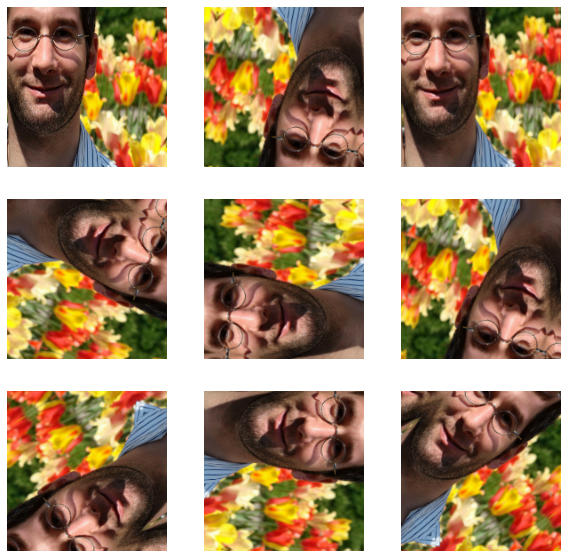

In [26]:
# rotate x degrees

data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(0.5)
])

draw_figures(data_augmentation, image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


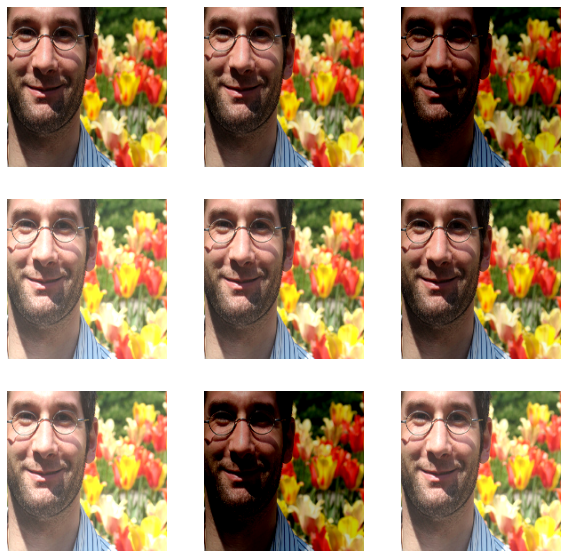

In [30]:
# make the image darker or lighter

data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomBrightness(0.001) # als reeds gedeeld is door 255 (maak dit niet te groot)
])

draw_figures(data_augmentation, image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


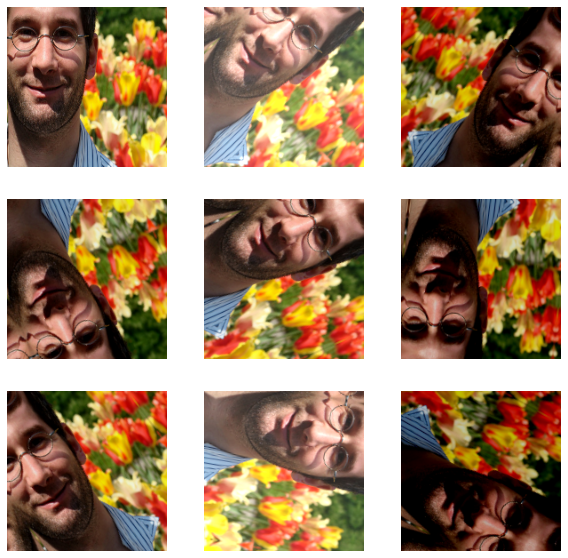

In [32]:
# these methods can be combined
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras import layers

data_augmentation = tf.keras.models.Sequential([
    RandomFlip( ),
    layers.RandomBrightness(0.001),
    tf.keras.layers.RandomRotation(0.5)
])

draw_figures(data_augmentation, image)

# Computer visie

Het tweede deel van deze notebook staat in het teken van computer visie.
Dit deel van Machine Learning is tegenwoordig heel populair en behaalt door middel van Deep Learning neurale netwerken heel goede resultaten bij het interpreteren van beelden en video.
De toepassingen van Computer visie zijn omvangrijk, bijvoorbeeld:
* Medische wereld: interpreteren scans, robots om te helpen bij kinesie therapie
* Mobiliteit: Zelfrijdende auto's
* Productie: Magazijnen waar robots zelf items halen of kijken hoe ze iets in elkaar moeten steken
* Gaming: Geavanceerde bots
* Media: Maken en detecteren van deep fakes/misinformatie

In deze domeinen wordt computervisie gebruikt zowel als regressie en classificatie techniek.
Daarnaast zijn ook transformers veel voorkomend. Transformers zijn neurale netwerken die een beeld omzetten in een ander beeld. 
Dit wordt bijvoorbeeld gebruikt voor image segmentation waarbij je kan kijken waar in de figuur welke objecten aanwezig zijn om daarop analyses te doen.

Hier gaan we werken met een standaard classificatieprobleem binnen het domein van computervisie, namelijk de CIFAR10-dataset.
Deze dataset bestaat uit 60000 32x32 kleurbeelden (50000 trainingsdata, 10000 testdata). 
Er zijn 10 mogelijke klassen in deze dataset met 6000 beelden per klasse.
De mogelijke klassen zijn:
* airplane 
* automobile 
* bird 
* cat 
* deer 
* dog 
* frog 
* horse 
* ship 
* truck

Deze oefening gaan we uitwerken in drie stappen:
* Data inladen
* Data augmentation
* Opstellen neuraal netwerk

## Data inlezen

De cifar10 dataset is een standaard dataset waarvan de tensors eenvoudig kunnen ingeladen worden door gebruik te maken van de tf.keras.datasets functionaliteit.
Dit gebeurt hieronder

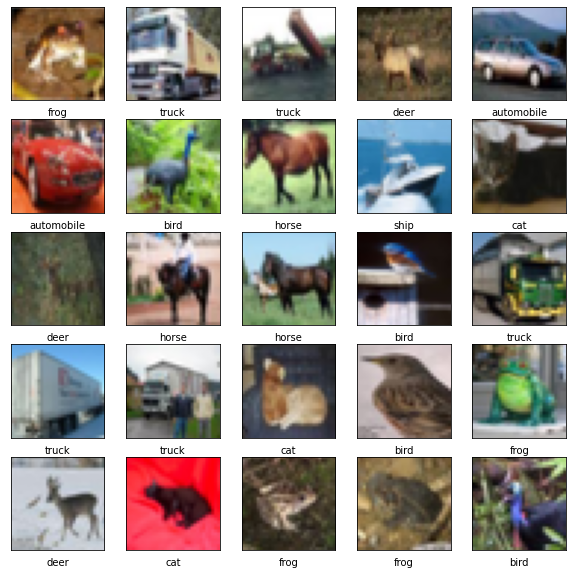

In [33]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]/255.0)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Data augmentation

Na het inlezen kunnen we een preprocessing stap toevoegen die rescaling en data augmentation uitvoert.
Dit gebeurt in de code hieronder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


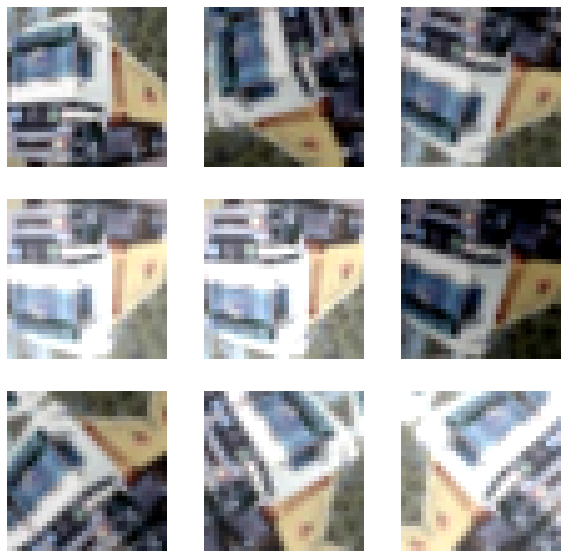

In [36]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    RandomFlip( ),
    layers.RandomBrightness(0.001),
    tf.keras.layers.RandomRotation(0.5)
])

draw_figures(data_augmentation, train_images[1])



## Convolutionele neurale netwerken

Op basis van bovenstaande stappen kunnen we nu een neuraal netwerk opbouwen om deze figuren te classificeren.
Klassiek zou je hier meerdere Dense layers voor gebruiken.
Computer visie is echter een complex probleem waar het onvoldoende is om individuele pixelwaarden te weten voor een goede classificatie uit te voeren.
Indien je dit toch met een klassiek fully-connected neuraal netwerk te doen zou je heel veel neuronen en lagen moeten hebben om deze verbanden goed te capteren.

De state-of-the-art neurale netwerken binnen computer visie plaatsen eerst een aantal lagen voor het neurale netwerken waarbij deze features geextraheerd worden.

Deze neurale netwerken worden Convolutionele Neurale Netwerken genoemd (CNN).
De naam hiervan komt voort uit het feit dat ze gebruik maken van Convolutionele lagen.
Naast deze convolutionele lagen wordt er ook vaak gebruik gemaakt van Pooling lagen om de dimensies te reduceren en zo de performantie te verbeteren.

Een goede uitleg met grafische steuntjes kan je vinden op [deze pagina](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

### Convolutionele lagen

De basis van een convolutionele laag is het concept van een convolutie.
Een convolutie is een mathematische operatie waarbij data uit verschillende bronnen wordt verbonden/samengevoegd.
In beeldverwerking wordt dit al lang gebruikt om bijvoorbeeld een blur-effect te introduceren, ruis te verminderen of randen scherper te maken. 

In neurale netwerken worden Convolutionele lagen gebruikt om randen te detecteren.
In de eerste laag zijn dit letterlijk de randen/lijnen van de figuur maar dieper liggende lagen detecteren hogere orde features zoals gezichten, banden, ogen, ...

Deze convolutie/feature extraction wordt uitgevoerd door een kernel. Dit is een kleine matrix die een aantal pixelwaarden samenvoegd met bepaalde gewichten. Deze gewichten worden getrained.
Let wel op dezelfde kernel gebruikt wordt voor een hele feature-map. Hierdoor wordt het aantal gewichten beperkt.

Bij het opstellen van een convolutionele laag moet je een aantal zaken kiezen. Deze keuzes bepalen de dimensies van de outputlaag en de structuur van de onderliggende lagen dus je bestudeerd best de dimensies van de in- en output van deze lagen om vlot te kunnen werken.

De hyperparameters van een convolutionele laag zijn:
* Dimensies van de input
    * 1D -> convolutie in de tijd
    * 2D -> convolutie over beelden
    * 3D -> convolutie over volumes, bvb video (images in de tijd) of 3d-modellen bij medische beeldvorming
* De kernel-dimensie: hoe groot is het venster waarin pixels samengevoegd worden
    * Typisch 3x3 of 5x5 (deze getallen zijn oneven zodat er een centrum pixel is, normaal ook gelijk in beide dimensies maar dat is niet verplicht)
    * Hoe kleiner de figuur hoe kleiner je je kernel wilt. Het is belangrijk om lokale data te gebruiken
* De stride: Hoeveel waarden/pixels schuift de kernel op elke stappen
    * Vaak 1 maar kan ook 2 of 3 zijn
* Padding: Hoe vang je de gevallen op dat de kernel buiten de figuur zou komen
    * No-padding: Kernel kan niet buiten de randen van de figuur gaan (valid padding in tensorflow). Hierdoor kan de dimensie van de output verkleind worden
    * Zero-Padding: Nullen worden toegevoegd indien de kernel buiten de randen van de figuur zou gaan (same padding in tensorflow)
* Aantal kernels: Hoeveel keer dat we deze convolutie willen uitvoeren = aantal "feature maps" die uit de laag komen = aantal "features" die herkend worden zoals oren, ogen, banden, ...
* Activation function
* Regularizers

Omdat een aantal van deze operaties de grootte van de figuren beinvloed gaan we dit eerst inoefenen aan de hand van een aantal voorbeelden.
Hierbij gaan we uit van de figuren die we hierboven berekend hebben die RGB beelden zijn (drie kanalen) van 32x32 pixels.

Wat is de output van een convolutionele laag met de hyperparameters:
* 1 kernel, Kernel=3x3, stride=1, padding = zero/same padding


In [37]:
image =tf.cast(tf.expand_dims(train_images[1], 0),tf.float32)
# expand_dims om een dimensie vooraan toe te voegen
# NN (batch_size, height, width, channels)  -> images is (heigth, width, channels)
# expand dims maakt van het image (1, height, widht, channels)

convolutie = tf.keras.layers.Conv2D(1, kernel_size=(3,3), strides=1, padding="same")

convolutie(image).shape        # expand_dims om een array van images te maken van 1 image

TensorShape([1, 32, 32, 1])

* 5 kernel, Kernel=3x3, stride=1, padding = no/valid padding

In [38]:

convolutie = tf.keras.layers.Conv2D(5, kernel_size=(3,3), strides=1, padding="valid")

convolutie(image).shape

TensorShape([1, 30, 30, 5])

* 5 kernel, Kernel=5x5, stride=2, padding = zero/same padding

In [39]:

convolutie = tf.keras.layers.Conv2D(5, kernel_size=(5,5), strides=2, padding="same")

convolutie(image).shape

TensorShape([1, 16, 16, 5])

* 5 kernel, Kernel=5x5, stride=2, padding = no/valid padding

In [40]:

convolutie = tf.keras.layers.Conv2D(5, kernel_size=(5,5), strides=2, padding="valid")

convolutie(image).shape

TensorShape([1, 14, 14, 5])

### Pooling lagen

Een probleem/beperking met het concept van convolutionele lagen is dat kleine beweging van de feature resulteren in een andere feature map/andere output. 
Dit komt omdat de convolutie de exacte positie van de feature bijhoudt.

De impact van deze kleine veranderingen (die bijvoorbeeld de impact zijn van onze augmentaties) wordt typisch vermeden door down-sampling uit te voeren. 
Hierdoor bekomen we een lagere resolutie waar echter nog steeds de belangrijkste en grootste features in gecapteerd zijn. 

In neurale netwerken kan deze downsampling uitgevoerd worden door de stride van de convolutie doorheen het beeld te vergroten.
Dit is echter een niet zo robuste aanpak en typisch wordt er gekozen om gebruik te maken van een pooling laag.

Dit is een laag die toegevoegd wordt na de activatiefunctie van de convolutionele laag.
Deze pooling laag voert dan deze downsampling uit door een bepaalde operatie uit te voeren.
Veruit de meest gebruikte operaties hiervoor zijn:
* Average pooling: Gemiddelde feature aanwezig in de buurt
* Maximum pooling: Sterkste, meest prominente, meest duidelijke feature

Deze operatie op zich voert nog geen downsampling uit.
Het downsamplen komt voort uit het feit dat deze laag een kleine groep pixels bekijkt (kernel/filter) en dit kijkvenster met een bepaalde stap verschuift (stride).
**In bijna alle gevallen wordt gebruik gemaakt van een 2x2 venster dat verschuift met een stap van 2.**
Dit houdt in dat de dimensie van de input gehalveerd wordt door het toepassen van een pooling laag



Indien we een standaard MaxPooling laag (filter of 2x2 en stride of 2) uitvoeren op de originele figuur (32x32x3), welke dimensie heeft de output dan?

In [41]:
pooling = tf.keras.layers.MaxPooling2D()

pooling(image).shape

TensorShape([1, 16, 16, 3])

### Full example

Een Convolutioneel Neuraal Netwerken bestaat uit dus eerst 1 of meerdere Convolutionele lagen gevolgd door een Pooling laag. 
Deze twee lagen worden afgewisseld tot je denkt voldoende diepte te hebben. Dit hangt af van de input van je netwerk en wat je probeert te bereiken. 
Wanneer er gestopt wordt met de convolutionele en pooling lagen is er een Flatten layer.
Deze laag doet niet zo veel behalve de dimensie van de tensor aanpassen zodat het een 1-dimensionele rij wordt.
Dit kan dan als input dienen voor een fully-connected neuraal netwerk bestaande uit 1 of meerdere Dense lagen.

Een voorbeeld waar een volledig CNN uitgelegd worden kan je [hier](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480) bestuderen.
Hieronder gaan we het voorbeeld waarmee we hierboven begonnen waren verder afwerken.


In [44]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), strides=1, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D()
])

model(image)

<tf.Tensor: shape=(1, 16, 16, 5), dtype=float32, numpy=
array([[[[0.00000000e+00, 1.65854037e-01, 1.01791985e-01,
          9.19860125e-01, 1.39358914e+00],
         [0.00000000e+00, 6.88648373e-02, 3.21056843e-01,
          6.45530939e-01, 1.13898754e+00],
         [0.00000000e+00, 1.77485108e-01, 2.35315084e-01,
          7.82721102e-01, 8.89798939e-01],
         ...,
         [0.00000000e+00, 3.32107954e-02, 1.48556158e-01,
          4.82860059e-01, 5.70043266e-01],
         [2.52225827e-02, 3.82293202e-02, 1.55140147e-01,
          5.67235470e-01, 5.91113508e-01],
         [1.37375504e-01, 0.00000000e+00, 8.22199583e-02,
          3.65428001e-01, 4.85468000e-01]],

        [[0.00000000e+00, 2.95482546e-01, 6.32170141e-02,
          4.61097121e-01, 1.49148321e+00],
         [0.00000000e+00, 7.10731149e-02, 0.00000000e+00,
          5.74155629e-01, 1.48417842e+00],
         [1.48200169e-02, 1.37726516e-01, 9.78499427e-02,
          4.12095755e-01, 1.25437307e+00],
         ...,
     

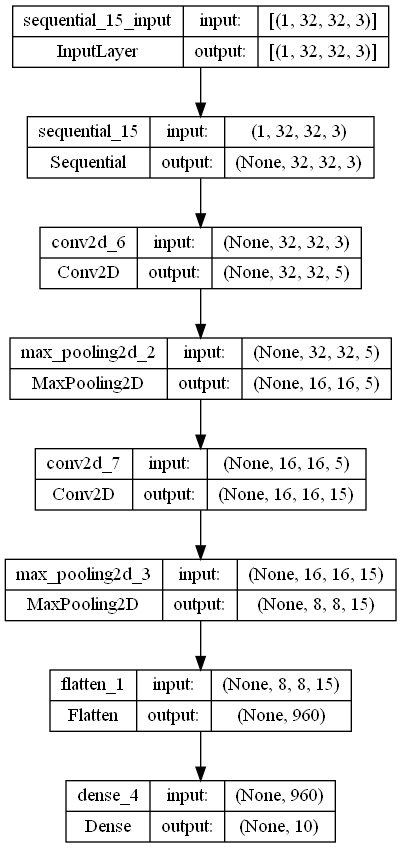

In [46]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), strides=1, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(15, kernel_size=(3,3), strides=1, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),       # Convolutioneel gedeelte naar fully connected gedeelte
    tf.keras.layers.Dense(10, activation="softmax")
])

model(image)

tf.keras.utils.plot_model(model, show_shapes=True)

In [47]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 5)         140       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 5)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 15)        690       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 15)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 960)             

In [48]:


# output test of the model 
model(image)

# train
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

Epoch 1/5
1563/1563 [==============================] - 29s 16ms/step - loss: 1.9165 - accuracy: 0.3033 - val_loss: 1.8017 - val_accuracy: 0.3641
Epoch 2/5
1563/1563 [==============================] - 23s 15ms/step - loss: 1.7714 - accuracy: 0.3621 - val_loss: 1.7947 - val_accuracy: 0.3612
Epoch 3/5
1563/1563 [==============================] - 23s 15ms/step - loss: 1.7085 - accuracy: 0.3879 - val_loss: 1.7171 - val_accuracy: 0.3849
Epoch 4/5
1563/1563 [==============================] - 23s 15ms/step - loss: 1.6722 - accuracy: 0.4022 - val_loss: 1.6604 - val_accuracy: 0.4053
Epoch 5/5
1563/1563 [==============================] - 23s 15ms/step - loss: 1.6488 - accuracy: 0.4080 - val_loss: 1.7096 - val_accuracy: 0.3892


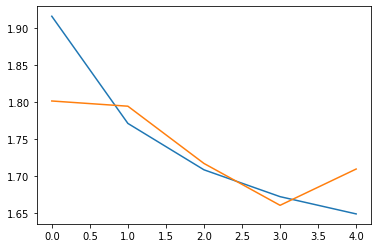

In [49]:
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), batch_size= 32, epochs= 5, shuffle=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])